# **Import Libraries**

In [1]:
import matplotlib.pyplot as plt
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary

#**Model**
### Here we create a sequential network of convolution and linear layers to predict the mnist digit & the sum of predicted digit & random number



In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #layer1
        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), 
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.Dropout(0.1),
                                   nn.Conv2d(16, 16, 3, padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.Dropout(0.1),
                                   nn.MaxPool2d(2, 2))
        #layer2
        self.conv2 = nn.Sequential(nn.Conv2d(16, 16, 3, padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.Dropout(0.1),
                                   nn.Conv2d(16, 16, 3, padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.Dropout(0.1),
                                   nn.Conv2d(16, 16, 3, padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.Dropout(0.1),
                                   nn.MaxPool2d(2, 2))
        #layer2
        self.conv3 =  nn.Sequential(nn.Conv2d(16, 16, 3),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.Dropout(0.1),
                                    nn.Conv2d(16, 16, 3),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.Conv2d(16, 32, 3))
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 10) #This layer corresponds mnist digit prediction
        
        #Output for mnist digit prediction
        self.sm = nn.Softmax(dim=-1)
        self.adder = nn.Sequential(  #Linear network which accepts two numbers(mnist predicted output and random number bw 0 to 9)
            nn.Linear(20, 64), 
            nn.ReLU(inplace=True), 
            nn.Linear(64, 64), 
            nn.ReLU(inplace=True), 
            nn.Linear(64, 19) # Onehot encoded output for sum of two numbers
        )
       
    def forward(self, x, inp_numbers):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        
        pred_digit = self.fc(output) #This layer outputs the predicted digit for mnist image
        
        pred_digit_softmaxed = self.sm(pred_digit)
        pred_sum = self.adder(torch.cat([pred_digit_softmaxed, F.one_hot(inp_numbers, num_classes=10)], dim=-1)) #Concatenate one hot encoded mnist digit & random rumber

        return pred_digit, pred_sum


In [3]:
print(Net())

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, i

#**Dataset Class**
Lets create MNISTWrapper dataset class that should override 3 methods:  
1. **\__init__()**: Initialization like reading image paths
2. **\__len__()**: Should return the number of items
3. **\__getitem__(i)**: Should return $i^{th}$ data-point


In [4]:
class MNISTWrapper(Dataset):
    def __init__(self, dataset, tfms):
        self.dataset = dataset
        self.tfms = tfms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        rand_number = torch.randint(0, 10, (1,1)).long()
        actual_sum = label + rand_number
        return img, label, rand_number.item(), actual_sum.item()

# **Data Transformations and Test/Train DataLoaders**
A Dataloader is a wrapper around a Dataset that puts images in a batch and lets us iterate over the batches. A Dataloader can be created by just passing our dataset to its contructor.

Additionally, it takes the following arguments:

batch_size: How many data-points to put together in a batch
shuffle: Whether to randomly shuffle the data order. Its important that we set this to True for the training set, and False for the test set.
num_workers: How many processes to spawn in loading the data. This can become a bottleneck if your GPU is fast enough. Set this to the number of cores / processors available.

In [5]:
def get_training_dataloader(mean, std, batch_size=16, num_workers=2, shuffle=True):
    transform_train = transforms.Compose([
        transforms.RandomRotation(5),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    #download mnist train dataset
    mnist_training = torchvision.datasets.MNIST(
        root='./mnist_data', download=True, transform=transform_train, train=True)
    mnist_training = MNISTWrapper(mnist_training, transform_train)
    #create dataloader
    mnist_training_loader = DataLoader(
        mnist_training, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return mnist_training_loader

In [6]:
def get_test_dataloader(mean, std, batch_size=16, num_workers=2, shuffle=True):
    transform_test = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
     #download mnist test dataset
    mnist_test = torchvision.datasets.MNIST(
        root='./mnist_data', download=True, transform=transform_test, train=False)
    mnist_test = MNISTWrapper(mnist_test, transform_test)
    #create dataloader
    mnist_test_loader = DataLoader(
        mnist_test, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return mnist_test_loader

#**Train function**

In [7]:
def train(net, optimizer, loss_function, mnist_training_loader, devices, epoch):
    net.train()
    for batch_index, (images, labels, rand_numbers, actual_sums) in enumerate(mnist_training_loader):
        #copy the data to cuda
        labels = labels.to(f"cuda:{devices[0]}")
        images = images.to(f"cuda:{devices[0]}")
        rand_numbers = rand_numbers.to(f"cuda:{devices[0]}")
        actual_sums = actual_sums.to(f"cuda:{devices[0]}")

        # Init
        optimizer.zero_grad()

        #predict
        pred_digits, pred_sums = net(images, rand_numbers)

        # calculate loss for digit prediction
        loss_pred = loss_function(pred_digits, labels).mean()

        # calculate loss for sum of two numbers
        loss_sum = loss_function(pred_sums, actual_sums).mean()
        
        #final loss calculated by adding prediction loss & sum loss
        loss = loss_pred + loss_sum

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 0:
            print('Training Epoch: {epoch} [{batch_index}/{total_batches}]\tLoss: {:0.4f}\tLR: {:0.6f}'.format(
                loss.item(),
                optimizer.param_groups[0]['lr'],
                epoch=epoch,
                batch_index=batch_index,
                total_batches=len(mnist_training_loader)
            ))

# **Model evaluation**

In [8]:
@torch.no_grad()
def eval_training(net, loss_function, mnist_test_loader, devices, epoch=0, tb=True):
    net.eval()

    test_loss = 0.0  # cost function error
    correct_digits = 0.0
    correct_sums = 0.0

    for (images, labels, rand_numbers, actual_sums) in mnist_test_loader:

        images = images.to(f"cuda:{devices[0]}")
        labels = labels.to(f"cuda:{devices[0]}")
        rand_numbers = rand_numbers.to(f"cuda:{devices[0]}")
        actual_sums = actual_sums.to(f"cuda:{devices[0]}")

        pred_digits, pred_sums = net(images, rand_numbers)
        loss_pred = loss_function(pred_digits, labels).mean()
        loss_sum = loss_function(pred_sums, actual_sums).mean()
        loss = loss_pred + loss_sum

        test_loss += loss.item()
        _, digit_preds = pred_digits.max(1)
        correct_digits += digit_preds.eq(labels).sum()
        _, sum_preds = pred_sums.max(1)
        correct_sums += sum_preds.eq(actual_sums).sum()

    print('Evaluating Network.....')
    print('Test set: Epoch: {}, Average loss: {:.4f}, Digit Accuracy: {:.4f}, Sum Accuracy: {:.4f}'.format(
        epoch,
        test_loss / len(mnist_test_loader.dataset),
        correct_digits.float() / len(mnist_test_loader.dataset),
        correct_sums.float() / len(mnist_test_loader.dataset),
    ))
    print()

    return ((correct_digits.float() + correct_sums.float()) / 2) / len(mnist_test_loader.dataset)

#**Data transformations on training set**

In [9]:
transform_train = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081))
])
mnist_training = torchvision.datasets.MNIST(
    root='./mnist_data', download=True, transform=transform_train, train=True)
mnist_training = MNISTWrapper(mnist_training, transform_train)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# **Lets set the device and train the model**

In [10]:
devices = [0, 1]
net = Net().to(f"cuda:{devices[0]}")

#train dataloader
mnist_training_loader = get_training_dataloader(
    (0.1307),
    (0.3081),
    num_workers=4,
    batch_size=1024,
    shuffle=True
)

#test dataloader
mnist_test_loader = get_test_dataloader(
    (0.1307),
    (0.3081),
    num_workers=4,
    batch_size=1024,
    shuffle=False
)

#calculate loss 
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2,
                        momentum=0.9, weight_decay=5e-4)

best_acc = 0
for epoch in range(1, 20 + 1):
    train(net, optimizer, loss_function, mnist_training_loader, devices, epoch)
    acc = eval_training(net, loss_function, mnist_test_loader, devices, epoch)
    if acc > best_acc:
        best_acc = acc

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training Epoch: 1 [0/59]	Loss: 5.2718	LR: 0.010000
Training Epoch: 1 [10/59]	Loss: 5.0588	LR: 0.010000
Training Epoch: 1 [20/59]	Loss: 4.6491	LR: 0.010000
Training Epoch: 1 [30/59]	Loss: 4.1022	LR: 0.010000
Training Epoch: 1 [40/59]	Loss: 3.7026	LR: 0.010000
Training Epoch: 1 [50/59]	Loss: 3.4171	LR: 0.010000
Evaluating Network.....
Test set: Epoch: 1, Average loss: 0.0033, Digit Accuracy: 0.9129, Sum Accuracy: 0.0981

Training Epoch: 2 [0/59]	Loss: 3.2545	LR: 0.010000
Training Epoch: 2 [10/59]	Loss: 3.1639	LR: 0.010000
Training Epoch: 2 [20/59]	Loss: 3.1006	LR: 0.010000
Training Epoch: 2 [30/59]	Loss: 3.0736	LR: 0.010000
Training Epoch: 2 [40/59]	Loss: 3.0388	LR: 0.010000
Training Epoch: 2 [50/59]	Loss: 3.0358	LR: 0.010000
Evaluating Network.....
Test set: Epoch: 2, Average loss: 0.0030, Digit Accuracy: 0.9501, Sum Accuracy: 0.0985

Training Epoch: 3 [0/59]	Loss: 2.9929	LR: 0.010000
Training Epoch: 3 [10/59]	Loss: 2.9617	LR: 0.010000
Training Epoch: 3 [20/59]	Loss: 2.9392	LR: 0.010000

# **Test data transformation**

In [11]:
transform_test = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307),(0.3081))
])
mnist_test = torchvision.datasets.MNIST(
    root='./mnist_data', download=True, transform=transform_test, train=False)
mnist_test = MNISTWrapper(mnist_test, transform_test)

#**Let's test the model for digit and sum prediction**

Inputs:
Random number: 3
Outputs:
Predicted digit: 9
Predicted sum: 12


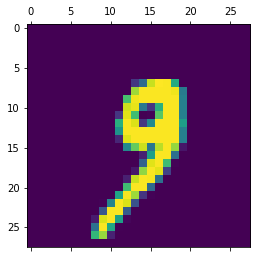

In [12]:
image, label, rand_number, actual_sum = mnist_test[1000]
print(f"Inputs:\nRandom number: {rand_number}")
plt.matshow(image.numpy()[0])
pred_digit, pred_sum = net(image.unsqueeze(0).to(f"cuda:{devices[0]}"), torch.LongTensor([rand_number]).to(f"cuda:{devices[0]}"))
_, pred_digit = pred_digit.max(1)
_, pred_sum = pred_sum.max(1)
print(f"Outputs:\nPredicted digit: {pred_digit.item()}\nPredicted sum: {pred_sum.item()}")


Inputs:
Random number: 8
Outputs:
Predicted digit: 6
Predicted sum: 14


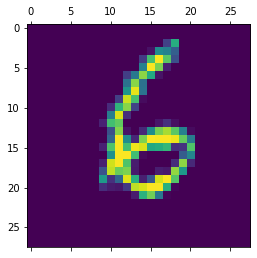

In [13]:
#get random data
image, label, rand_number, actual_sum = mnist_test[2000]
print(f"Inputs:\nRandom number: {rand_number}")
plt.matshow(image.numpy()[0])
#unsqueeze input and copy data to cuda 
pred_digit, pred_sum = net(image.unsqueeze(0).to(f"cuda:{devices[0]}"), torch.LongTensor([rand_number]).to(f"cuda:{devices[0]}"))
_, pred_digit = pred_digit.max(1)
_, pred_sum = pred_sum.max(1)
print(f"Outputs:\nPredicted digit: {pred_digit.item()}\nPredicted sum: {pred_sum.item()}")

Inputs:
Random number: 7
Outputs:
Predicted digit: 6
Predicted sum: 13


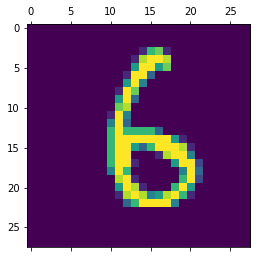

In [14]:
image, label, rand_number, actual_sum = mnist_test[3000]
print(f"Inputs:\nRandom number: {rand_number}")
plt.matshow(image.numpy()[0])
pred_digit, pred_sum = net(image.unsqueeze(0).to(f"cuda:{devices[0]}"), torch.LongTensor([rand_number]).to(f"cuda:{devices[0]}"))
_, pred_digit = pred_digit.max(1)
_, pred_sum = pred_sum.max(1)
print(f"Outputs:\nPredicted digit: {pred_digit.item()}\nPredicted sum: {pred_sum.item()}")